/Users/chenyk/aaspip.pyseistr/pyseistr/plot.py:160: UserWarning: The following kwargs were not used by contour: 'barlabel'
  _ = ax.contourf(
/Users/chenyk/aaspip.pyseistr/pyseistr/plot.py:165: UserWarning: The following kwargs were not used by contour: 'barlabel'
  _ = ax.contourf(
/Users/chenyk/aaspip.pyseistr/pyseistr/plot.py:170: UserWarning: The following kwargs were not used by contour: 'barlabel'
  C = ax.contourf(


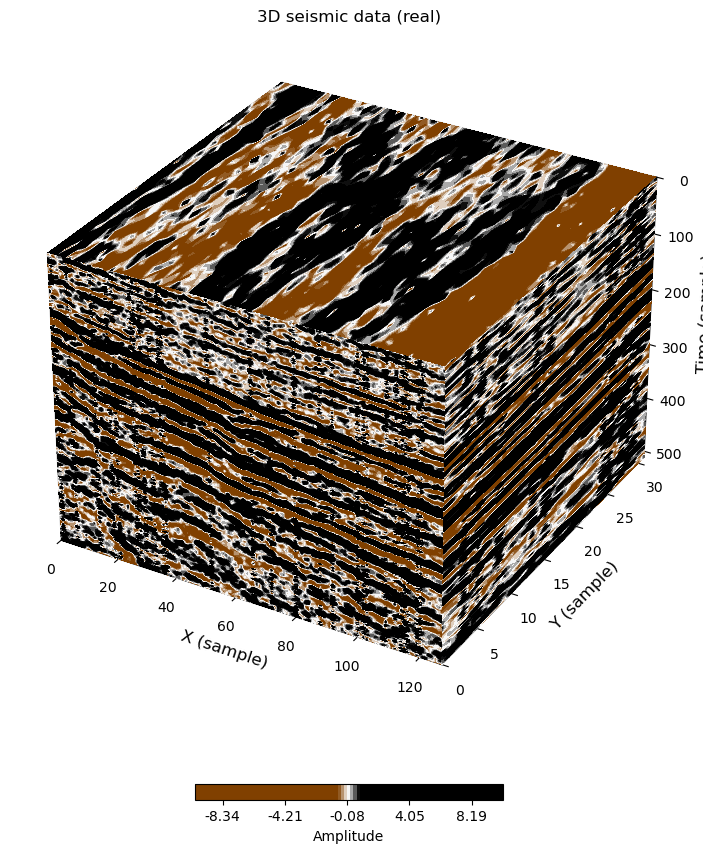

In [1]:
# Prepared On Feb 19, 2025 by Yangkang Chen, UT-Austin
#
# As a reproduced example for three papers
# [1] Chen, Y., Zhang, M., Bai, M., & Chen, W. (2019). Improving the signal‐to‐noise ratio of seismological datasets by unsupervised machine learning. Seismological Research Letters, 90(4), 1552-1564.
# [2] Saad, O. M., & Chen, Y. (2021). A fully unsupervised and highly generalized deep learning approach for random noise suppression. Geophysical Prospecting, 69(4), 709-726.
# [3] Yang, L., Wang, S., Chen, X., Saad, O.M., Chen, W., Oboue, Y.A.S.I. and Chen, Y., 2021. Unsupervised 3-D random noise attenuation using deep skip autoencoder. IEEE Transactions on Geoscience and Remote Sensing, 60, pp.1-16.
#
# NOTE: both examples are unsupervised learning approaches. 
# Please use the latest pyseistr package:
# https://github.com/aaspip/pyseistr
#
# Environment: 
# CPU machine
# conda create -n uml python=3.11.7
# conda activate uml
# conda install ipython notebook
# pip install matplotlib==3.8.0 tensorflow==2.14.0 scikit-learn==1.2.2 seaborn==0.13.2 
# 
# GPU machine
# conda create -n uml python=3.10.14
# conda activate uml
# conda install ipython notebook
# pip install matplotlib==3.8.0 tensorflow==2.11.0 scikit-learn==1.2.2 seaborn==0.13.2 
# conda install -c anaconda cudnn==8.2.1
#
#
#First, Download the data from link below
# https://github.com/aaspip/data/blob/main/drr_real3d_erratic.mat
import scipy
data = scipy.io.loadmat('drr_real3d_erratic.mat')
dt=data['d1']
dx=data['d2']
dy=data['d3']
real=data['datan']

import numpy as np
from pyseistr import genplane3d,plot3d
import matplotlib.pyplot as plt

dz=1;dx=1;dy=1;
[nz,nx,ny]=real.shape;

plot3d(real,vmin=-1,vmax=1,figsize=(14,10),z=np.arange(nz)*dz,x=np.arange(nx)*dx,y=np.arange(ny)*dy,barlabel='Amplitude',showf=False,close=False)
plt.gca().set_xlabel("X (sample)",fontsize='large', fontweight='normal')
plt.gca().set_ylabel("Y (sample)",fontsize='large', fontweight='normal')
plt.gca().set_zlabel("Time (sample)",fontsize='large', fontweight='normal')
plt.title('3D seismic data (real)')
plt.savefig(fname='real3d.png',format='png',dpi=300)
plt.show()

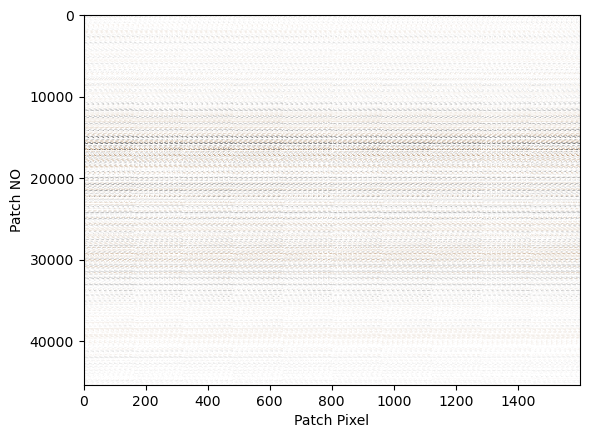

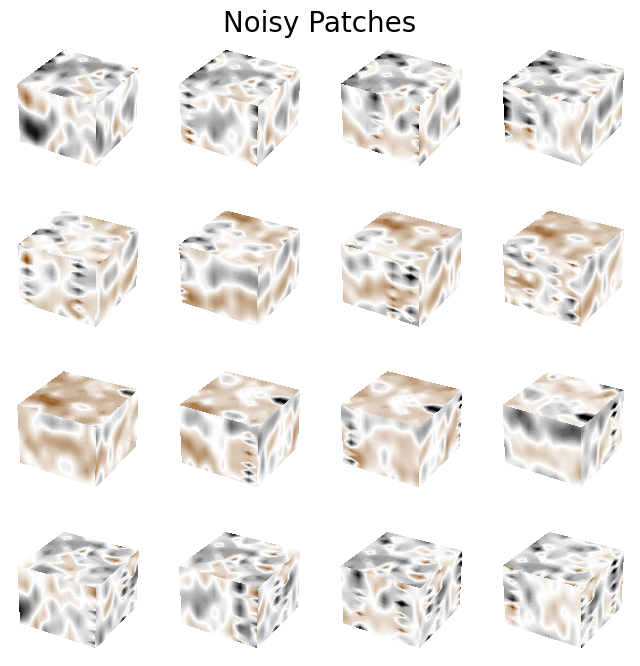

In [2]:
from pyseistr import patch3d,patch3d_inv,snr
Xnoisy=patch3d(real,l1=16,l2=10,l3=10,s1=8,s2=2,s3=2);

from pyseistr import cseis
plt.imshow(Xnoisy,aspect='auto',cmap=cseis());plt.ylabel('Patch NO');plt.xlabel('Patch Pixel');plt.show()

# plot noisy patches
plt.figure(figsize=(8,8))
for ii in range(16):
            ax=plt.subplot(4,4,ii+1,projection='3d')
            plot3d(Xnoisy[600+ii,:].reshape(16,10,10,order='F'),ifnewfig=False,showf=False,close=False)
            plt.gca().axis('off')
ax = plt.gcf().add_subplot(111, aspect='auto');plt.gca().axis('off');plt.title("Noisy Patches",size=20)
plt.show()


In [3]:
from keras import layers
from keras.models import Model
# from tensorflow.keras.layers import Input, Dense, Dropout, concatenate, LeakyReLU,BatchNormalization
# from tensorflow.keras.models import Model

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# The following architecture was used in 
# Chen, Y., Zhang, M., Bai, M., & Chen, W. (2019). Improving the signal‐to‐noise ratio of seismological datasets by unsupervised machine learning. Seismological Research Letters, 90(4), 1552-1564.

input = layers.Input(shape=(1600,))                            #or from tensorflow.keras.layers import Input, Dense
x = layers.Dense(128, activation="relu", name="layer1")(input)  
x = layers.Dense(1600, activation="linear", name="layer2")(x)  

# Autoencoder
autoencoder = Model(input,x)
autoencoder.summary()

# Compile
autoencoder.compile(optimizer="adam", loss='mse')


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer1 (Dense)                  │ (None, 128)            │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer2 (Dense)                  │ (None, 1600)           │       206,400 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 411,328 (1.57 MB)

 Trainable params: 411,328 (1.57 MB)

 Non-trainable params: 0 (0.00 B)

In [4]:
import datetime
today=datetime.date.today()
weightname='best_model_%s.weights.h5'%str(today)


checkpoint = ModelCheckpoint(filepath=weightname,monitor='val_loss',mode = 'min',verbose=1,save_weights_only=True,save_best_only=True)
lr_reducer = ReduceLROnPlateau(factor=0.1,cooldown=0,patience=50,min_lr=0.5e-6,monitor='val_loss',mode = 'min',verbose= 1)

autoencoder.fit(Xnoisy,Xnoisy, batch_size=128, verbose=1,epochs=20,callbacks=[checkpoint,lr_reducer],validation_split=0.2)


Epoch 1/20
268/284 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1422
Epoch 1: val_loss improved from inf to 0.57238, saving model to best_model_2025-02-19.weights.h5
284/284 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.1237 - val_loss: 0.5724 - learning_rate: 0.0010
Epoch 2/20
282/284 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5934
Epoch 2: val_loss improved from 0.57238 to 0.51740, saving model to best_model_2025-02-19.weights.h5
284/284 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5932 - val_loss: 0.5174 - learning_rate: 0.0010
Epoch 3/20
282/284 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5382
Epoch 3: val_loss improved from 0.51740 to 0.49095, saving model to best_model_2025-02-19.weights.h5
284/284 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5381 - val_loss: 0.4909 - learning_rate: 0.0010
Epoch 4/20
284/284 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5114
Epoch 4: val_loss improved from 0.49095 to 0.47297, saving model to best_model_2025-02-19.weights.h5
284/284 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms

In [5]:
Xout = autoencoder.predict(Xnoisy)

1418/1418 ━━━━━━━━━━━━━━━━━━━━ 1s 350us/step


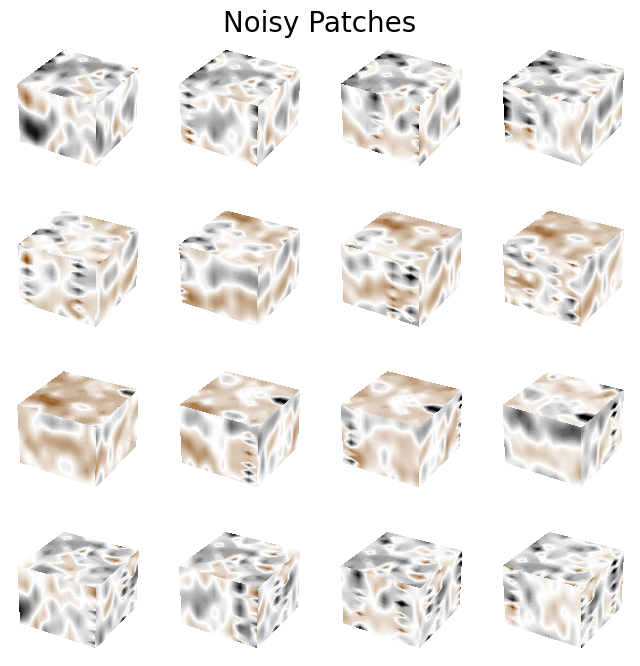

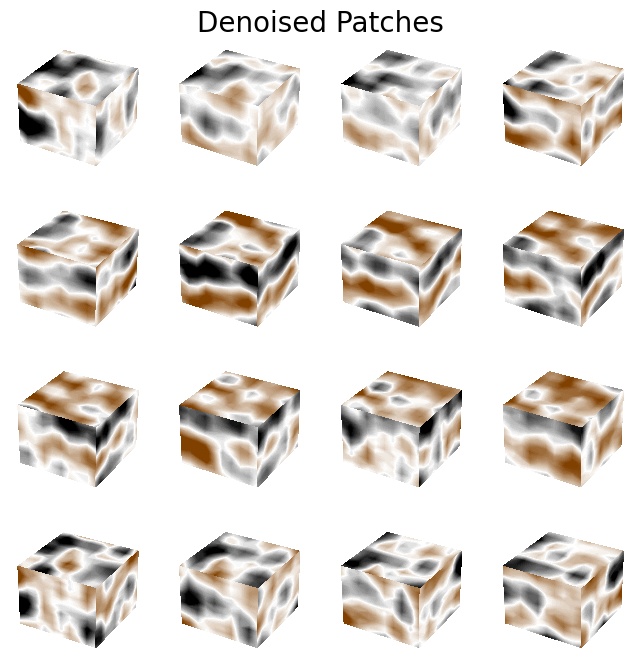

In [6]:


plt.figure(figsize=(8,8))
for ii in range(16):
            ax=plt.subplot(4,4,ii+1,projection='3d')
            plot3d(Xnoisy[600+ii,:].reshape(16,10,10,order='F'),ifnewfig=False,showf=False,close=False)
            plt.gca().axis('off')
ax = plt.gcf().add_subplot(111, aspect='auto');plt.gca().axis('off');plt.title("Noisy Patches",size=20)
plt.show()

plt.figure(figsize=(8,8))
for ii in range(16):
            ax=plt.subplot(4,4,ii+1,projection='3d')
            plot3d(Xout[600+ii,:].reshape(16,10,10,order='F'),ifnewfig=False,showf=False,close=False)
            plt.gca().axis('off')
ax = plt.gcf().add_subplot(111, aspect='auto');plt.gca().axis('off');plt.title("Denoised Patches",size=20)
plt.show()

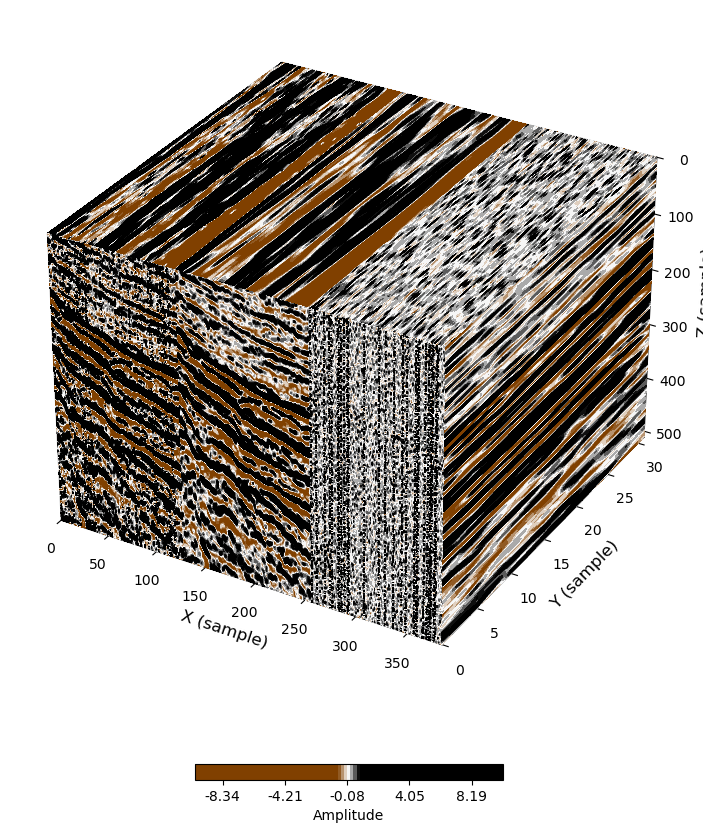

In [12]:
# reconstruct data
denoised=patch3d_inv(Xout,nz,nx,ny,l1=16,l2=10,l3=10,s1=8,s2=2,s3=2);

plot3d(np.concatenate([real,denoised,real-denoised],axis=1),vmin=-1,vmax=1,figsize=(14,10),z=np.arange(nz)*dz,x=np.arange(nx*3)*dx,y=np.arange(ny)*dy,barlabel='Amplitude',showf=False,close=False)
plt.gca().set_xlabel("X (sample)",fontsize='large', fontweight='normal')
plt.gca().set_ylabel("Y (sample)",fontsize='large', fontweight='normal')
plt.gca().set_zlabel("Z (sample)",fontsize='large', fontweight='normal')
# plt.title('Clean:Noisy:Denoised:Noise SNR={SNR:.2f} dB'.format(SNR=snr(data,denoised,mode=2)))
plt.savefig(fname='real3d-denoised-erratic.png',format='png',dpi=300)
plt.show()

In [20]:
# For field data, using local similarity (Chen and Fomel, 2015) for evaluate the "signal leakage"
# !pip install pyortho

DEPRECATION: Loading egg at /opt/anaconda3/lib/python3.12/site-packages/SCons-4.8.1-py3.12.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
  Preparing metadata (setup.py) ... done
  Created wheel for pyortho: filename=pyortho-0.0.5.1-cp312-cp312-macosx_11_0_arm64.whl size=50677 sha256=a08b21651aebe137114a531450cc742a90c3a94e91c15a74075c0f3f4ce1801c
  Stored in directory: /Users/chenyk/Library/Caches/pip/wheels/cb/b0/02/f97b78ce36a56f762cd52c3f744cbc7fa61f8a66dadb8c7566
Successfully built pyortho


In [9]:
from pyortho import localsimic

In [10]:
signal=denoised;
noise=real-denoised;
simi1=localsimic(signal,noise,[5,5,5],niter=20);

512 128 32 5 5 5 20 0.0 1


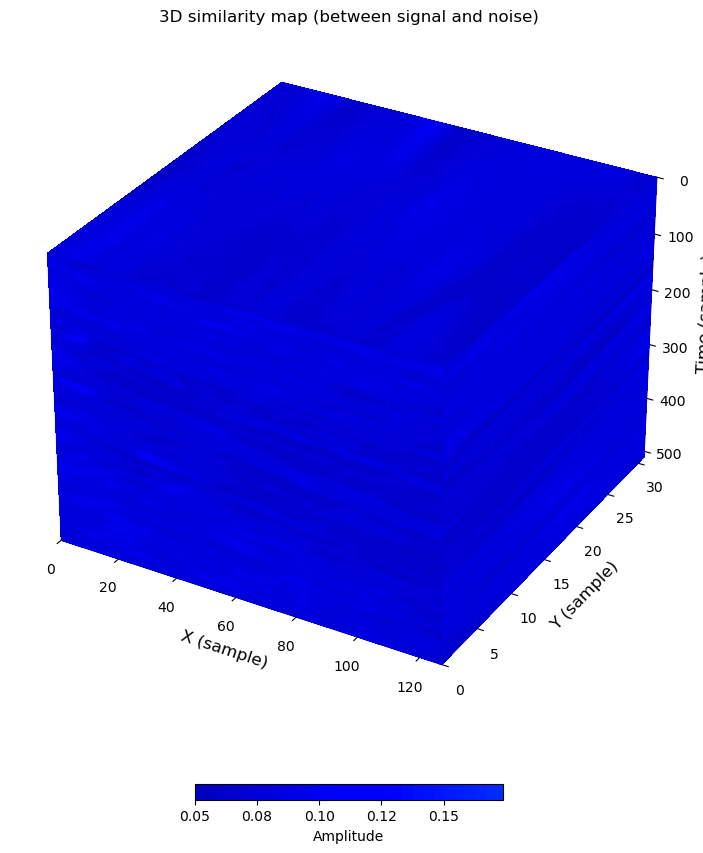

In [11]:
plot3d(simi1,vmin=0,vmax=1,cmap=plt.cm.jet,figsize=(14,10),z=np.arange(nz)*dz,x=np.arange(nx)*dx,y=np.arange(ny)*dy,barlabel='Amplitude',showf=False,close=False)
plt.gca().set_xlabel("X (sample)",fontsize='large', fontweight='normal')
plt.gca().set_ylabel("Y (sample)",fontsize='large', fontweight='normal')
plt.gca().set_zlabel("Time (sample)",fontsize='large', fontweight='normal')
plt.title('3D similarity map (between signal and noise)')
plt.savefig(fname='real3d-simi.png',format='png',dpi=300)
plt.show()
## This one is pretty successful (negligible signal leakage)

Epoch 1/20
277/284 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2006
Epoch 1: val_loss improved from inf to 0.18600, saving model to best_model_2025-02-19.weights.h5
284/284 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2004 - val_loss: 0.1860 - learning_rate: 0.0010
Epoch 2/20
280/284 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1936
Epoch 2: val_loss did not improve from 0.18600
284/284 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1936 - val_loss: 0.1866 - learning_rate: 0.0010
Epoch 3/20
283/284 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1941
Epoch 3: val_loss improved from 0.18600 to 0.18565, saving model to best_model_2025-02-19.weights.h5
284/284 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1941 - val_loss: 0.1856 - learning_rate: 0.0010
Epoch 4/20
284/284 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1929
Epoch 4: val_loss did not improve from 0.18565
284/284 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1929 - val_loss: 0.1860 - learning_rate: 0.0010
Epoch 5/20
282/284 ━━━━━━━━━━━━━━━━━━━━ 0s 4

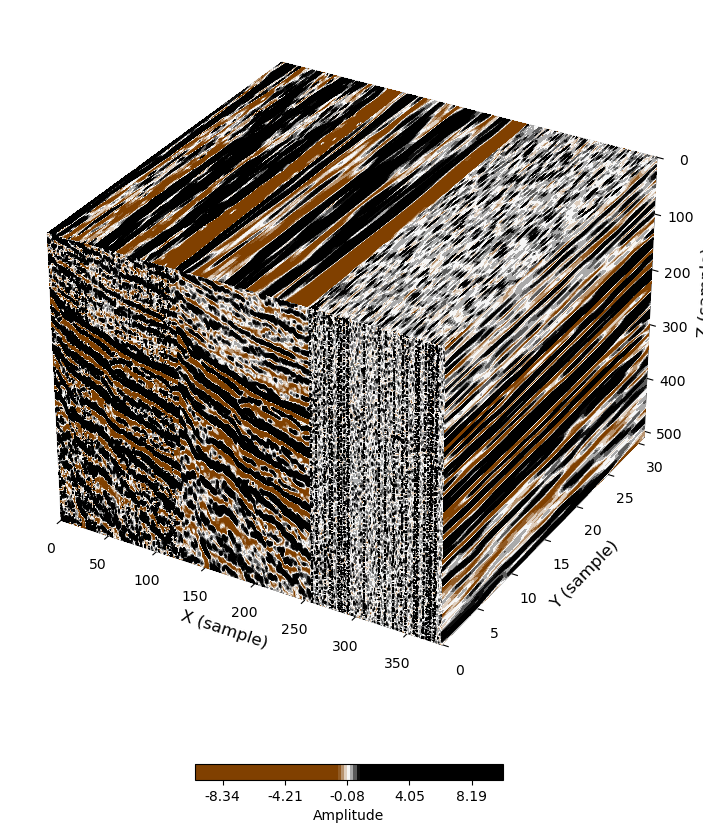

In [14]:
# Using Huber norm Loss Function
import tensorflow as tf
def huber_loss_mean(y_true, y_pred, clip_delta=1.3):
    error = y_true - y_pred
    abs_error = tf.keras.backend.abs(error)

    squared_loss = 0.5 * tf.keras.backend.square(error)
    linear_loss = clip_delta * (abs_error - 0.5 * clip_delta)

    return tf.keras.backend.mean(tf.where(abs_error < clip_delta, squared_loss, linear_loss))


autoencoder.compile(optimizer="adam", loss=huber_loss_mean) #from loss='mse'

# specify the model
import datetime
today=datetime.date.today()
weightname='best_model_%s.weights.h5'%str(today)
checkpoint = ModelCheckpoint(filepath=weightname,monitor='val_loss',mode = 'min',verbose=1,save_weights_only=True,save_best_only=True)
lr_reducer = ReduceLROnPlateau(factor=0.1,cooldown=0,patience=50,min_lr=0.5e-6,monitor='val_loss',mode = 'min',verbose= 1)

autoencoder.fit(Xnoisy,Xnoisy, batch_size=128, verbose=1,epochs=20,callbacks=[checkpoint,lr_reducer],validation_split=0.2)

# Predict
Xout = autoencoder.predict(Xnoisy)

# reconstruct data
denoised=patch3d_inv(Xout,nz,nx,ny,l1=16,l2=10,l3=10,s1=8,s2=2,s3=2);

plot3d(np.concatenate([real,denoised,real-denoised],axis=1),vmin=-1,vmax=1,figsize=(14,10),z=np.arange(nz)*dz,x=np.arange(nx*3)*dx,y=np.arange(ny)*dy,barlabel='Amplitude',showf=False,close=False)
plt.gca().set_xlabel("X (sample)",fontsize='large', fontweight='normal')
plt.gca().set_ylabel("Y (sample)",fontsize='large', fontweight='normal')
plt.gca().set_zlabel("Z (sample)",fontsize='large', fontweight='normal')
# plt.title('Clean:Noisy:Denoised:Noise SNR={SNR:.2f} dB'.format(SNR=snr(data,denoised,mode=2)))
plt.savefig(fname='real3d-denoised-erratic-huber.png',format='png',dpi=300)
plt.show()

512 128 32 5 5 5 20 0.0 1


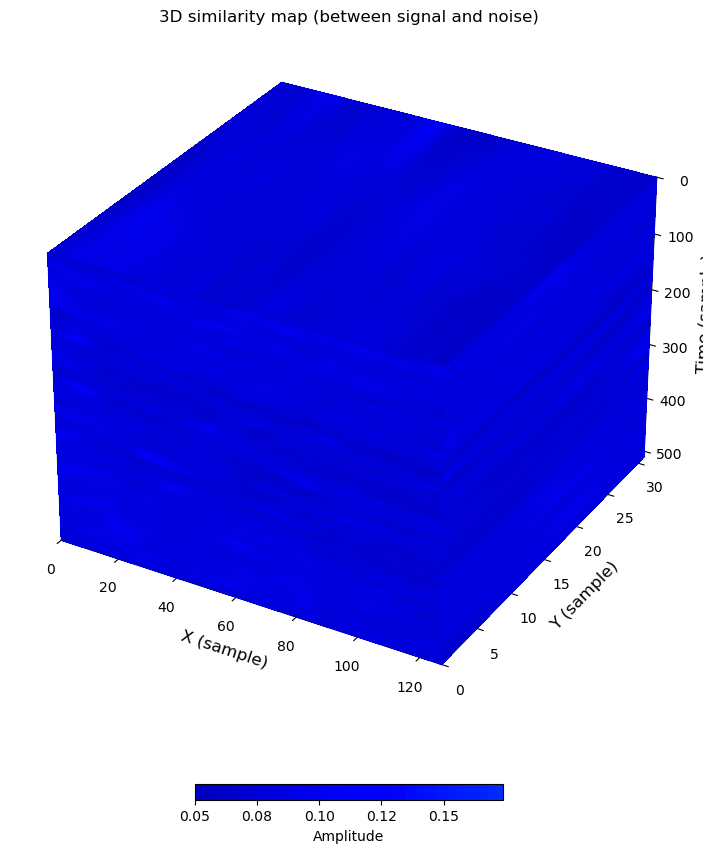

In [15]:
signal=denoised;
noise=real-denoised;
simi1=localsimic(signal,noise,[5,5,5],niter=20);

plot3d(simi1,vmin=0,vmax=1,cmap=plt.cm.jet,figsize=(14,10),z=np.arange(nz)*dz,x=np.arange(nx)*dx,y=np.arange(ny)*dy,barlabel='Amplitude',showf=False,close=False)
plt.gca().set_xlabel("X (sample)",fontsize='large', fontweight='normal')
plt.gca().set_ylabel("Y (sample)",fontsize='large', fontweight='normal')
plt.gca().set_zlabel("Time (sample)",fontsize='large', fontweight='normal')
plt.title('3D similarity map (between signal and noise)')
plt.savefig(fname='real3d-simi.png',format='png',dpi=300)
plt.show()

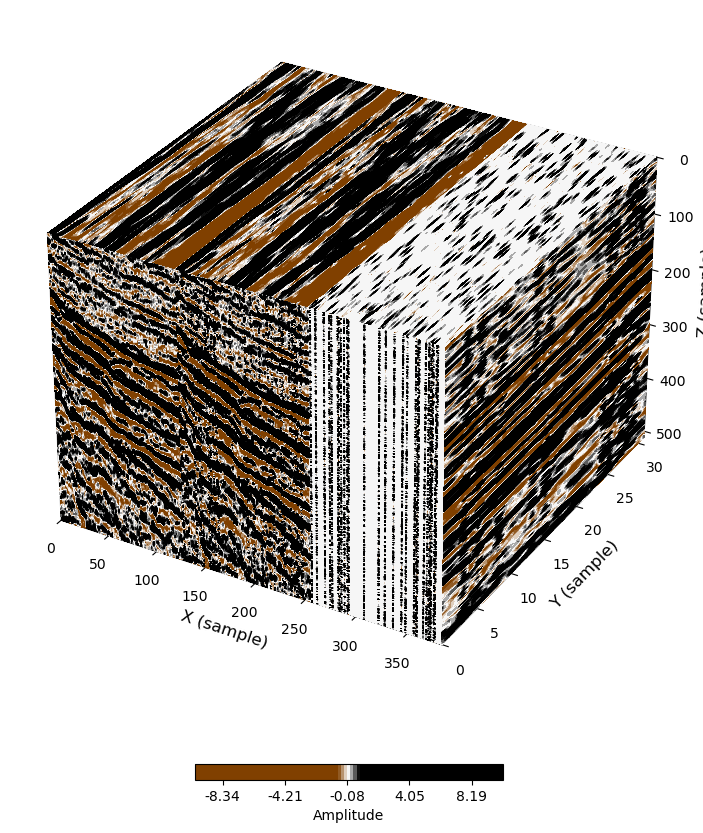

In [19]:
# no big differences
# Let's increase the amplitude of erratic noise to 10 times stronger

data1 = scipy.io.loadmat('drr_real3d.mat')['data']
data2 = scipy.io.loadmat('drr_real3d_erratic.mat')['datan']

noise_err=data2-data1;

plot3d(np.concatenate([data1,data2,data2-data1],axis=1),vmin=-1,vmax=1,figsize=(14,10),z=np.arange(nz)*dz,x=np.arange(nx*3)*dx,y=np.arange(ny)*dy,barlabel='Amplitude',showf=False,close=False)
plt.gca().set_xlabel("X (sample)",fontsize='large', fontweight='normal')
plt.gca().set_ylabel("Y (sample)",fontsize='large', fontweight='normal')
plt.gca().set_zlabel("Z (sample)",fontsize='large', fontweight='normal')
plt.savefig(fname='real3d-denoised-datacomp.png',format='png',dpi=300)
plt.show()


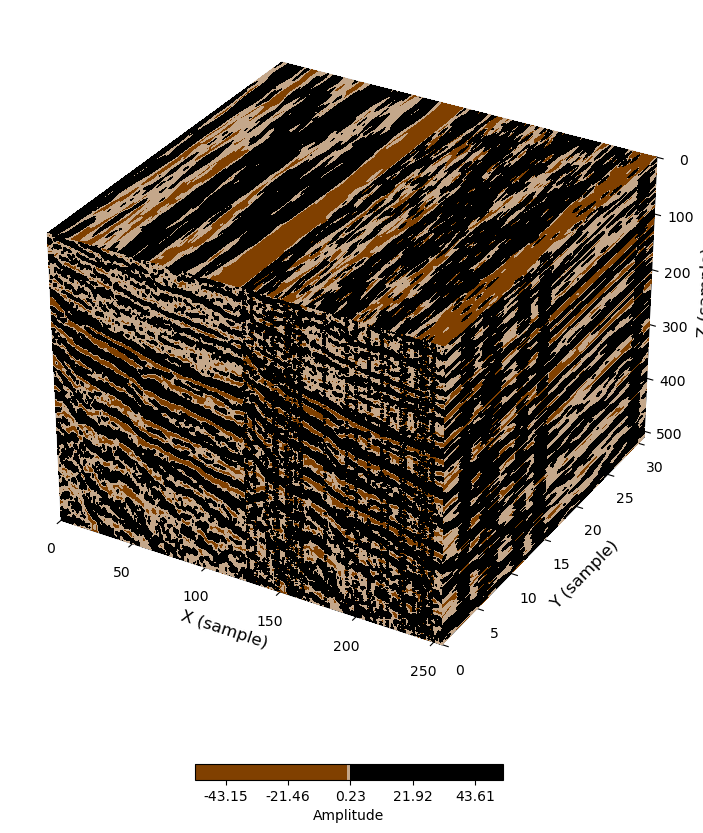

In [21]:
real2=data1+noise_err*10

plot3d(np.concatenate([data1,real2],axis=1),vmin=-1,vmax=1,figsize=(14,10),z=np.arange(nz)*dz,x=np.arange(nx*2)*dx,y=np.arange(ny)*dy,barlabel='Amplitude',showf=False,close=False)
plt.gca().set_xlabel("X (sample)",fontsize='large', fontweight='normal')
plt.gca().set_ylabel("Y (sample)",fontsize='large', fontweight='normal')
plt.gca().set_zlabel("Z (sample)",fontsize='large', fontweight='normal')
plt.savefig(fname='real3d-denoised-datacomp2.png',format='png',dpi=300)
plt.show()

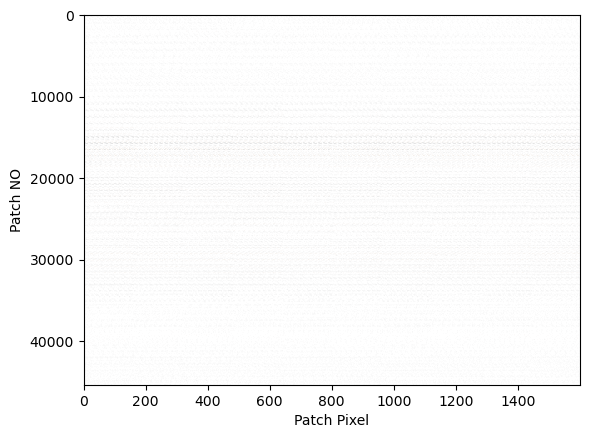

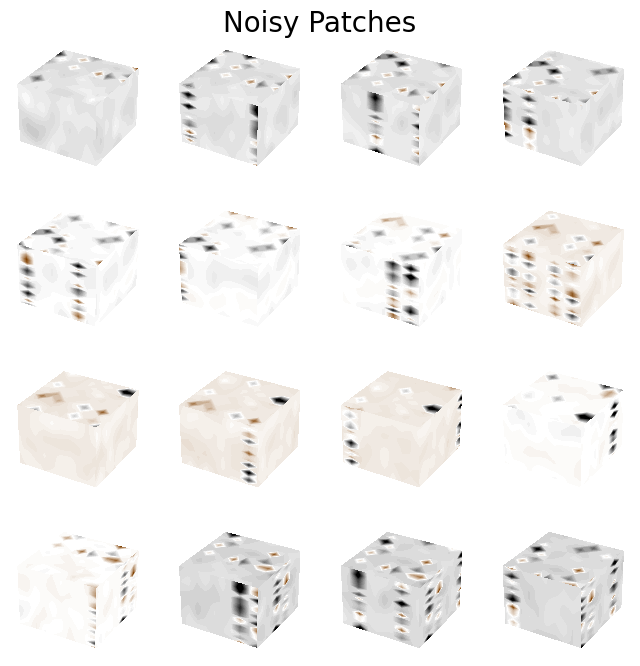

Epoch 1/20
280/284 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 26.4925
Epoch 1: val_loss improved from inf to 26.87645, saving model to best_model_2025-02-19.weights.h5
284/284 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 26.4917 - val_loss: 26.8765 - learning_rate: 0.0010
Epoch 2/20
273/284 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 26.2819
Epoch 2: val_loss improved from 26.87645 to 26.85779, saving model to best_model_2025-02-19.weights.h5
284/284 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 26.2848 - val_loss: 26.8578 - learning_rate: 0.0010
Epoch 3/20
279/284 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 26.2751
Epoch 3: val_loss did not improve from 26.85779
284/284 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 26.2753 - val_loss: 26.8654 - learning_rate: 0.0010
Epoch 4/20
283/284 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 26.1922
Epoch 4: val_loss improved from 26.85779 to 26.84793, saving model to best_model_2025-02-19.weights.h5
284/284 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 26.1925 - val_loss: 26.8

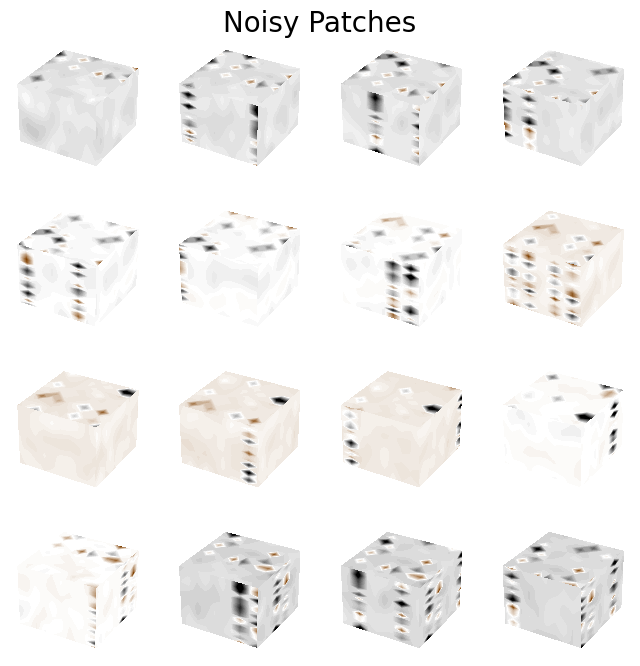

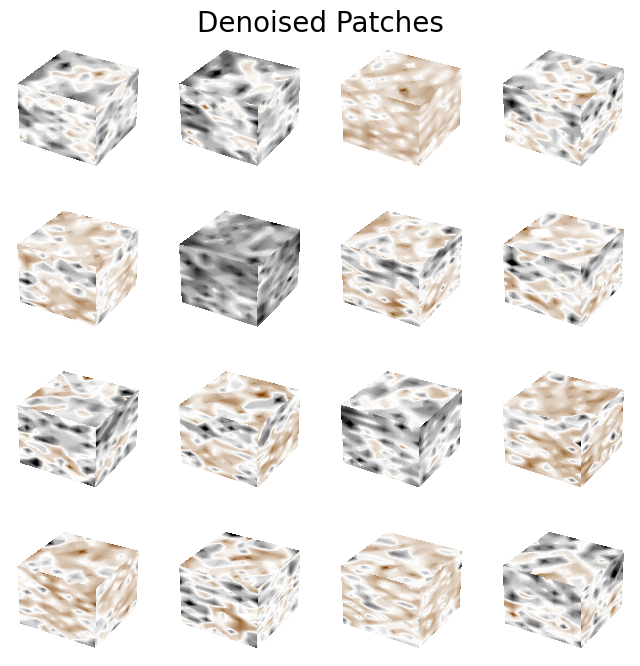

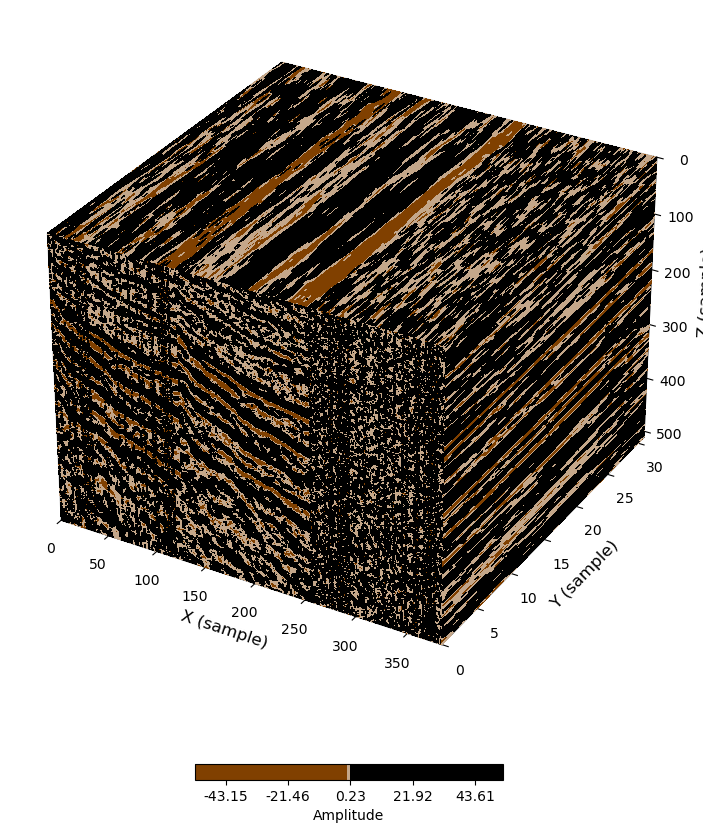

In [30]:
# Let's first see if 'MSE' loss function works

Xnoisy=patch3d(real2,l1=16,l2=10,l3=10,s1=8,s2=2,s3=2);

from pyseistr import cseis
plt.imshow(Xnoisy,aspect='auto',cmap=cseis());plt.ylabel('Patch NO');plt.xlabel('Patch Pixel');plt.show()

# plot noisy patches
plt.figure(figsize=(8,8))
for ii in range(16):
            ax=plt.subplot(4,4,ii+1,projection='3d')
            plot3d(Xnoisy[600+ii,:].reshape(16,10,10,order='F'),ifnewfig=False,showf=False,close=False)
            plt.gca().axis('off')
ax = plt.gcf().add_subplot(111, aspect='auto');plt.gca().axis('off');plt.title("Noisy Patches",size=20)
plt.show()

autoencoder.compile(optimizer="adam", loss='mse') #from loss='mse'

# specify the model
import datetime
today=datetime.date.today()
weightname='best_model_%s.weights.h5'%str(today)
checkpoint = ModelCheckpoint(filepath=weightname,monitor='val_loss',mode = 'min',verbose=1,save_weights_only=True,save_best_only=True)
lr_reducer = ReduceLROnPlateau(factor=0.1,cooldown=0,patience=50,min_lr=0.5e-6,monitor='val_loss',mode = 'min',verbose= 1)

autoencoder.fit(Xnoisy,Xnoisy, batch_size=128, verbose=1,epochs=20,callbacks=[checkpoint,lr_reducer],validation_split=0.2)

# Predict
Xout = autoencoder.predict(Xnoisy)


# reconstruct data
denoised=patch3d_inv(Xout,nz,nx,ny,l1=16,l2=10,l3=10,s1=8,s2=2,s3=2);

# Plot patch comparison
plt.figure(figsize=(8,8))
for ii in range(16):
            ax=plt.subplot(4,4,ii+1,projection='3d')
            plot3d(Xnoisy[600+ii,:].reshape(16,10,10,order='F'),ifnewfig=False,showf=False,close=False)
            plt.gca().axis('off')
ax = plt.gcf().add_subplot(111, aspect='auto');plt.gca().axis('off');plt.title("Noisy Patches",size=20)
plt.show()

plt.figure(figsize=(8,8))
for ii in range(16):
            ax=plt.subplot(4,4,ii+1,projection='3d')
            plot3d(Xout[600+ii,:].reshape(16,10,10,order='F'),ifnewfig=False,showf=False,close=False)
            plt.gca().axis('off')
ax = plt.gcf().add_subplot(111, aspect='auto');plt.gca().axis('off');plt.title("Denoised Patches",size=20)
plt.show()


# Plot denoising comparison
plot3d(np.concatenate([real2,denoised,real2-denoised],axis=1),vmin=-1,vmax=1,figsize=(14,10),z=np.arange(nz)*dz,x=np.arange(nx*3)*dx,y=np.arange(ny)*dy,barlabel='Amplitude',showf=False,close=False)
plt.gca().set_xlabel("X (sample)",fontsize='large', fontweight='normal')
plt.gca().set_ylabel("Y (sample)",fontsize='large', fontweight='normal')
plt.gca().set_zlabel("Z (sample)",fontsize='large', fontweight='normal')
# plt.title('Clean:Noisy:Denoised:Noise SNR={SNR:.2f} dB'.format(SNR=snr(data,denoised,mode=2)))
plt.savefig(fname='real3d-denoised-erratic2.png',format='png',dpi=300)
plt.show()



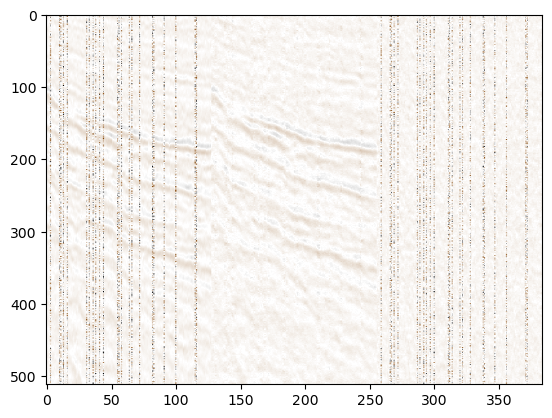

In [31]:
import pyseistr
ind=15;
plt.imshow(np.concatenate([real2[:,:,ind],denoised[:,:,ind],real2[:,:,ind]-denoised[:,:,ind]],axis=1),aspect='auto',cmap=pyseistr.cseis());


Epoch 1/20
270/284 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.6024
Epoch 1: val_loss improved from inf to 2.49125, saving model to best_model_2025-02-19.weights.h5
284/284 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.5987 - val_loss: 2.4913 - learning_rate: 0.0010
Epoch 2/20
284/284 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.4865
Epoch 2: val_loss improved from 2.49125 to 2.48031, saving model to best_model_2025-02-19.weights.h5
284/284 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.4865 - val_loss: 2.4803 - learning_rate: 0.0010
Epoch 3/20
282/284 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.4814
Epoch 3: val_loss improved from 2.48031 to 2.46943, saving model to best_model_2025-02-19.weights.h5
284/284 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.4814 - val_loss: 2.4694 - learning_rate: 0.0010
Epoch 4/20
274/284 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.4647
Epoch 4: val_loss improved from 2.46943 to 2.45423, saving model to best_model_2025-02-19.weights.h5
284/284 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms

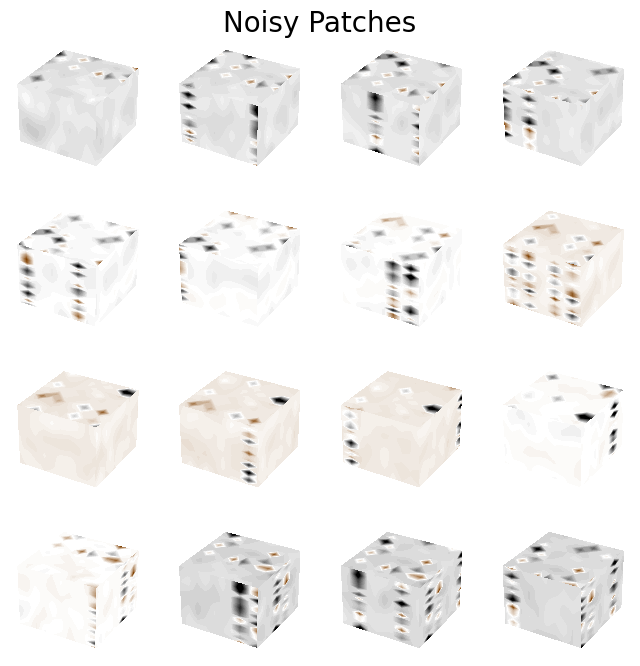

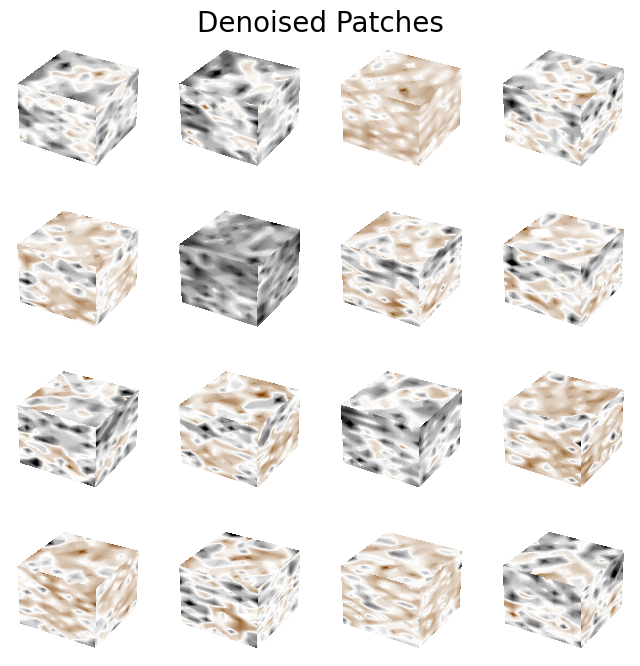

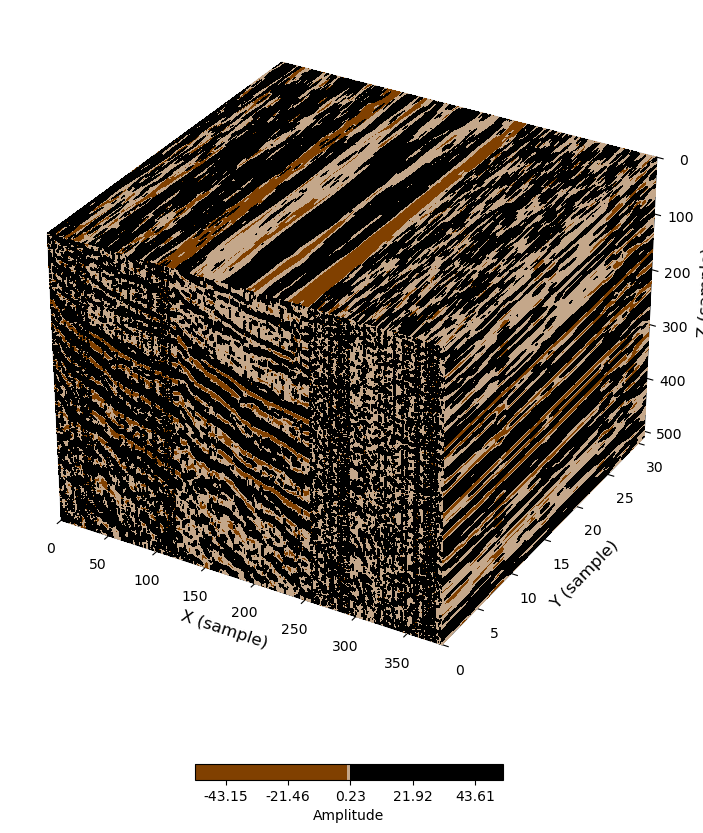

In [32]:
# Then, let's try Huber norm loss function

# Using Huber norm Loss Function
import tensorflow as tf
def huber_loss_mean(y_true, y_pred, clip_delta=1.3):
    error = y_true - y_pred
    abs_error = tf.keras.backend.abs(error)

    squared_loss = 0.5 * tf.keras.backend.square(error)
    linear_loss = clip_delta * (abs_error - 0.5 * clip_delta)

    return tf.keras.backend.mean(tf.where(abs_error < clip_delta, squared_loss, linear_loss))


autoencoder.compile(optimizer="adam", loss=huber_loss_mean) #from loss='mse'

# specify the model
import datetime
today=datetime.date.today()
weightname='best_model_%s.weights.h5'%str(today)
checkpoint = ModelCheckpoint(filepath=weightname,monitor='val_loss',mode = 'min',verbose=1,save_weights_only=True,save_best_only=True)
lr_reducer = ReduceLROnPlateau(factor=0.1,cooldown=0,patience=50,min_lr=0.5e-6,monitor='val_loss',mode = 'min',verbose= 1)

autoencoder.fit(Xnoisy,Xnoisy, batch_size=128, verbose=1,epochs=20,callbacks=[checkpoint,lr_reducer],validation_split=0.2)

# Predict
Xout2 = autoencoder.predict(Xnoisy)


# reconstruct data
denoised2=patch3d_inv(Xout2,nz,nx,ny,l1=16,l2=10,l3=10,s1=8,s2=2,s3=2);

# Plot patch comparison
plt.figure(figsize=(8,8))
for ii in range(16):
            ax=plt.subplot(4,4,ii+1,projection='3d')
            plot3d(Xnoisy[600+ii,:].reshape(16,10,10,order='F'),ifnewfig=False,showf=False,close=False)
            plt.gca().axis('off')
ax = plt.gcf().add_subplot(111, aspect='auto');plt.gca().axis('off');plt.title("Noisy Patches",size=20)
plt.show()

plt.figure(figsize=(8,8))
for ii in range(16):
            ax=plt.subplot(4,4,ii+1,projection='3d')
            plot3d(Xout[600+ii,:].reshape(16,10,10,order='F'),ifnewfig=False,showf=False,close=False)
            plt.gca().axis('off')
ax = plt.gcf().add_subplot(111, aspect='auto');plt.gca().axis('off');plt.title("Denoised Patches",size=20)
plt.show()


# Plot denoising comparison
plot3d(np.concatenate([real2,denoised2,real2-denoised2],axis=1),vmin=-1,vmax=1,figsize=(14,10),z=np.arange(nz)*dz,x=np.arange(nx*3)*dx,y=np.arange(ny)*dy,barlabel='Amplitude',showf=False,close=False)
plt.gca().set_xlabel("X (sample)",fontsize='large', fontweight='normal')
plt.gca().set_ylabel("Y (sample)",fontsize='large', fontweight='normal')
plt.gca().set_zlabel("Z (sample)",fontsize='large', fontweight='normal')
# plt.title('Clean:Noisy:Denoised:Noise SNR={SNR:.2f} dB'.format(SNR=snr(data,denoised,mode=2)))
plt.savefig(fname='real3d-denoised-erratic-huber2.png',format='png',dpi=300)
plt.show()

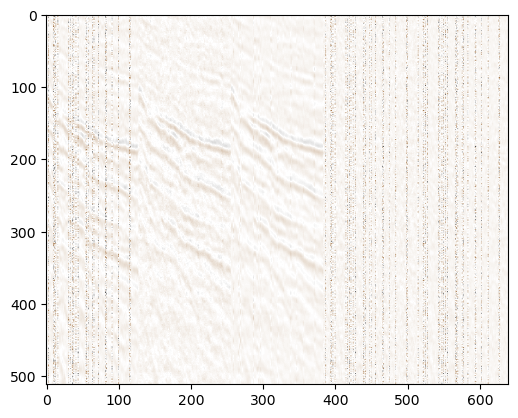

In [38]:
import pyseistr
ind=15;
plt.imshow(np.concatenate([real2[:,:,ind],denoised[:,:,ind],denoised2[:,:,ind],real2[:,:,ind]-denoised[:,:,ind],real2[:,:,ind]-denoised2[:,:,ind]],axis=1),cmap=pyseistr.cseis());



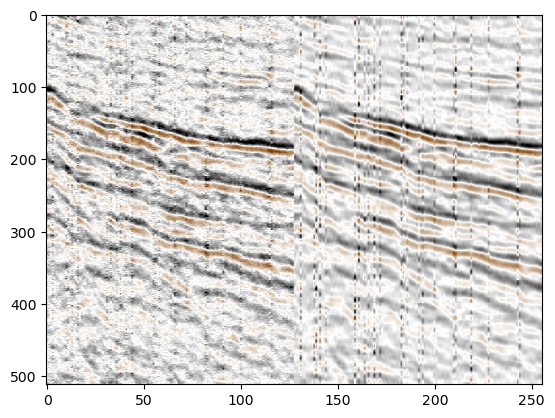

In [39]:
plt.imshow(np.concatenate([denoised[:,:,ind],denoised2[:,:,ind]],axis=1),aspect='auto',cmap=pyseistr.cseis());


512 128 32 5 5 5 20 0.0 1


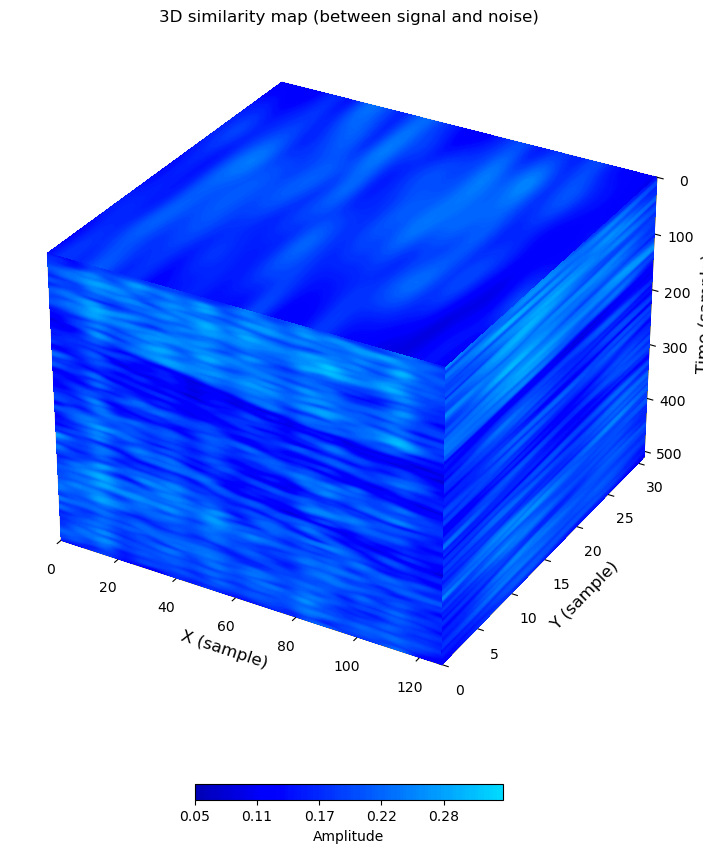

In [40]:
signal=denoised;
noise=real2-denoised;
simi1=localsimic(signal,noise,[5,5,5],niter=20);

plot3d(simi1,vmin=0,vmax=1,cmap=plt.cm.jet,figsize=(14,10),z=np.arange(nz)*dz,x=np.arange(nx)*dx,y=np.arange(ny)*dy,barlabel='Amplitude',showf=False,close=False)
plt.gca().set_xlabel("X (sample)",fontsize='large', fontweight='normal')
plt.gca().set_ylabel("Y (sample)",fontsize='large', fontweight='normal')
plt.gca().set_zlabel("Time (sample)",fontsize='large', fontweight='normal')
plt.title('3D similarity map (between signal and noise)')
plt.savefig(fname='real3d-simi-2.png',format='png',dpi=300)
plt.show()

# print(simi1.flatten().max())

512 128 32 5 5 5 20 0.0 1


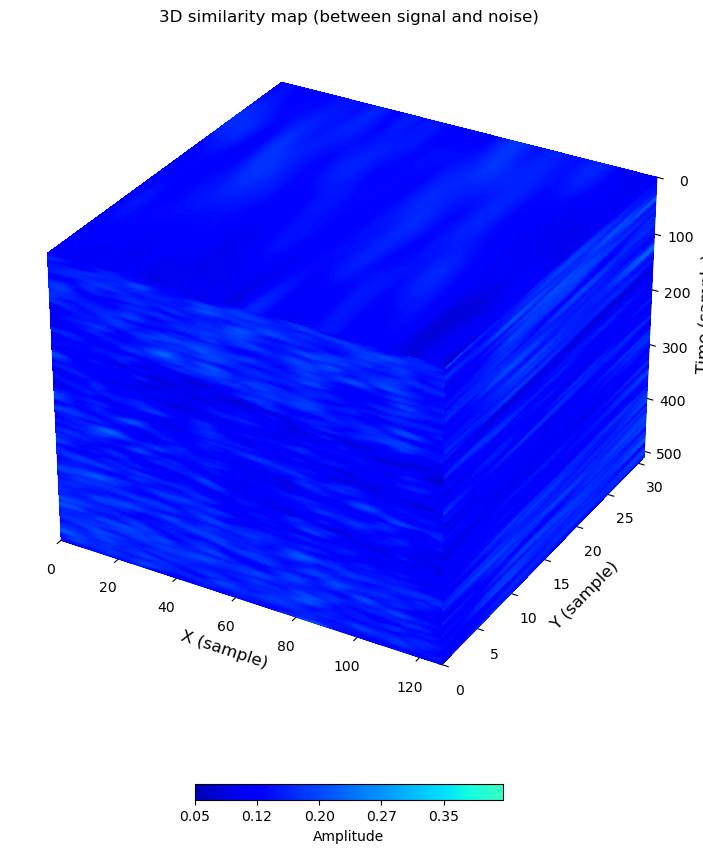

In [41]:
signal=denoised2;
noise=real2-denoised2;
simi2=localsimic(signal,noise,[5,5,5],niter=20);

plot3d(simi2,vmin=0,vmax=1,cmap=plt.cm.jet,figsize=(14,10),z=np.arange(nz)*dz,x=np.arange(nx)*dx,y=np.arange(ny)*dy,barlabel='Amplitude',showf=False,close=False)
plt.gca().set_xlabel("X (sample)",fontsize='large', fontweight='normal')
plt.gca().set_ylabel("Y (sample)",fontsize='large', fontweight='normal')
plt.gca().set_zlabel("Time (sample)",fontsize='large', fontweight='normal')
plt.title('3D similarity map (between signal and noise)')
plt.savefig(fname='real3d-simi-3.png',format='png',dpi=300)
plt.show()

# print(simi2.flatten().max())

Epoch 1/20
281/284 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 10.6804
Epoch 1: val_loss improved from inf to 10.71613, saving model to best_model_2025-02-19.weights.h5
284/284 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 10.6802 - val_loss: 10.7161 - learning_rate: 0.0010
Epoch 2/20
275/284 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 10.6377
Epoch 2: val_loss did not improve from 10.71613
284/284 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 10.6376 - val_loss: 10.7205 - learning_rate: 0.0010
Epoch 3/20
270/284 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 10.6052
Epoch 3: val_loss did not improve from 10.71613
284/284 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 10.6062 - val_loss: 10.7216 - learning_rate: 0.0010
Epoch 4/20
269/284 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 10.5909
Epoch 4: val_loss did not improve from 10.71613
284/284 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 10.5925 - val_loss: 10.7229 - learning_rate: 0.0010
Epoch 5/20
283/284 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 10.6090
Epoch 5: val_l

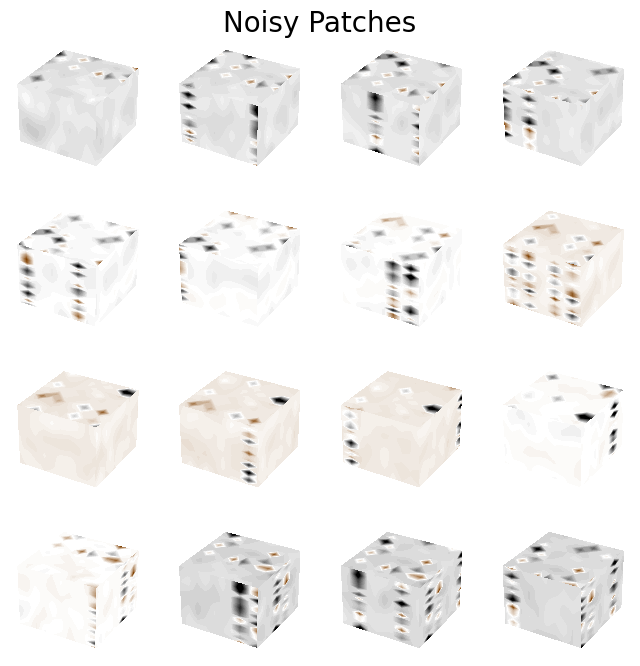

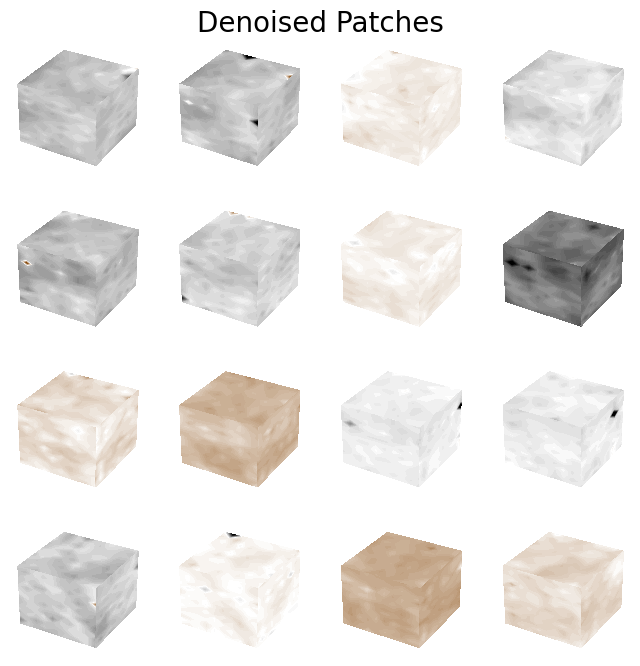

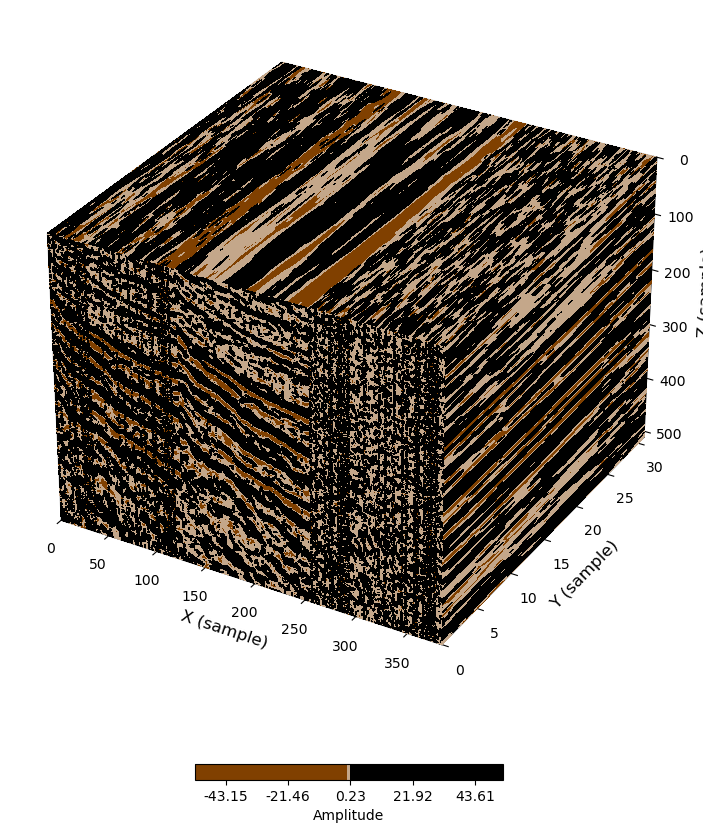

In [42]:
# Not too bad
# Let's twist a bit on clip_delta value of huber norm loss function
cvalue=1.3
cvalue=0.9
cvalue=10.0
def huber_loss_mean(y_true, y_pred, clip_delta=cvalue):
    error = y_true - y_pred
    abs_error = tf.keras.backend.abs(error)

    squared_loss = 0.5 * tf.keras.backend.square(error)
    linear_loss = clip_delta * (abs_error - 0.5 * clip_delta)

    return tf.keras.backend.mean(tf.where(abs_error < clip_delta, squared_loss, linear_loss))


autoencoder.compile(optimizer="adam", loss=huber_loss_mean) #from loss='mse'

# specify the model
import datetime
today=datetime.date.today()
weightname='best_model_%s.weights.h5'%str(today)
checkpoint = ModelCheckpoint(filepath=weightname,monitor='val_loss',mode = 'min',verbose=1,save_weights_only=True,save_best_only=True)
lr_reducer = ReduceLROnPlateau(factor=0.1,cooldown=0,patience=50,min_lr=0.5e-6,monitor='val_loss',mode = 'min',verbose= 1)

autoencoder.fit(Xnoisy,Xnoisy, batch_size=128, verbose=1,epochs=20,callbacks=[checkpoint,lr_reducer],validation_split=0.2)

# Predict
Xout3 = autoencoder.predict(Xnoisy)


# reconstruct data
denoised3=patch3d_inv(Xout3,nz,nx,ny,l1=16,l2=10,l3=10,s1=8,s2=2,s3=2);

# Plot patch comparison
plt.figure(figsize=(8,8))
for ii in range(16):
            ax=plt.subplot(4,4,ii+1,projection='3d')
            plot3d(Xnoisy[600+ii,:].reshape(16,10,10,order='F'),ifnewfig=False,showf=False,close=False)
            plt.gca().axis('off')
ax = plt.gcf().add_subplot(111, aspect='auto');plt.gca().axis('off');plt.title("Noisy Patches",size=20)
plt.show()

plt.figure(figsize=(8,8))
for ii in range(16):
            ax=plt.subplot(4,4,ii+1,projection='3d')
            plot3d(Xout3[600+ii,:].reshape(16,10,10,order='F'),ifnewfig=False,showf=False,close=False)
            plt.gca().axis('off')
ax = plt.gcf().add_subplot(111, aspect='auto');plt.gca().axis('off');plt.title("Denoised Patches",size=20)
plt.show()


# Plot denoising comparison
plot3d(np.concatenate([real2,denoised3,real2-denoised3],axis=1),vmin=-1,vmax=1,figsize=(14,10),z=np.arange(nz)*dz,x=np.arange(nx*3)*dx,y=np.arange(ny)*dy,barlabel='Amplitude',showf=False,close=False)
plt.gca().set_xlabel("X (sample)",fontsize='large', fontweight='normal')
plt.gca().set_ylabel("Y (sample)",fontsize='large', fontweight='normal')
plt.gca().set_zlabel("Z (sample)",fontsize='large', fontweight='normal')
# plt.title('Clean:Noisy:Denoised:Noise SNR={SNR:.2f} dB'.format(SNR=snr(data,denoised,mode=2)))
plt.savefig(fname='real3d-denoised-erratic-huber3.png',format='png',dpi=300)
plt.show()



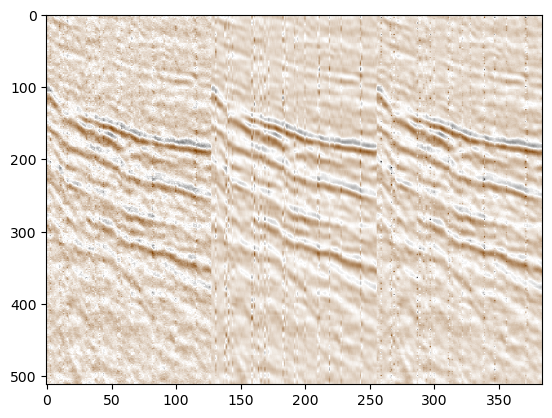

In [43]:
plt.imshow(np.concatenate([denoised[:,:,ind],denoised2[:,:,ind],denoised3[:,:,ind]],axis=1),aspect='auto',cmap=pyseistr.cseis());


Epoch 1/20
279/284 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 12.8548
Epoch 1: val_loss improved from inf to 13.04812, saving model to best_model_2025-02-19.weights.h5
284/284 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 12.8548 - val_loss: 13.0481 - learning_rate: 0.0010
Epoch 2/20
269/284 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 12.8314
Epoch 2: val_loss did not improve from 13.04812
284/284 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 12.8314 - val_loss: 13.0569 - learning_rate: 0.0010
Epoch 3/20
269/284 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 12.7887
Epoch 3: val_loss did not improve from 13.04812
284/284 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 12.7903 - val_loss: 13.0606 - learning_rate: 0.0010
Epoch 4/20
269/284 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 12.8018
Epoch 4: val_loss did not improve from 13.04812
284/284 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 12.8021 - val_loss: 13.0641 - learning_rate: 0.0010
Epoch 5/20
278/284 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 12.7948
Epoch 5: val_l

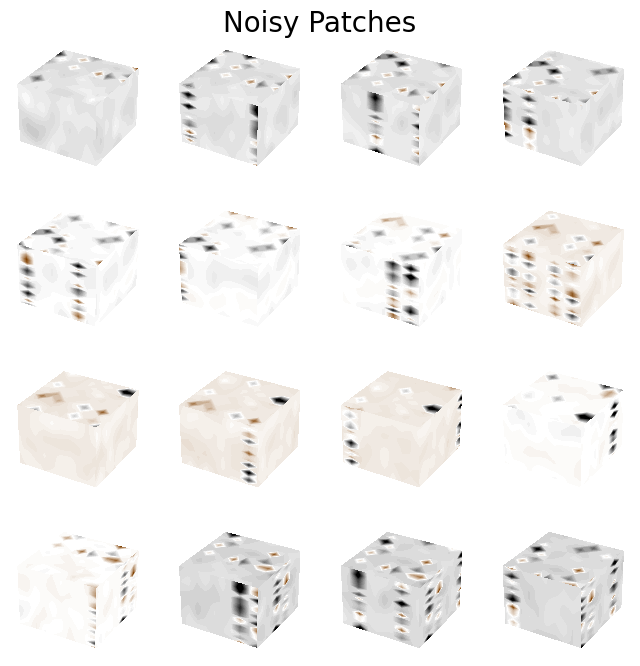

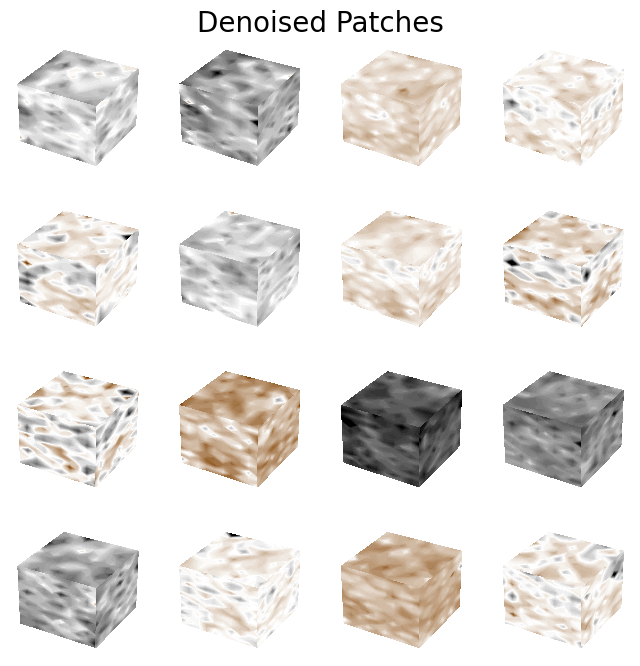

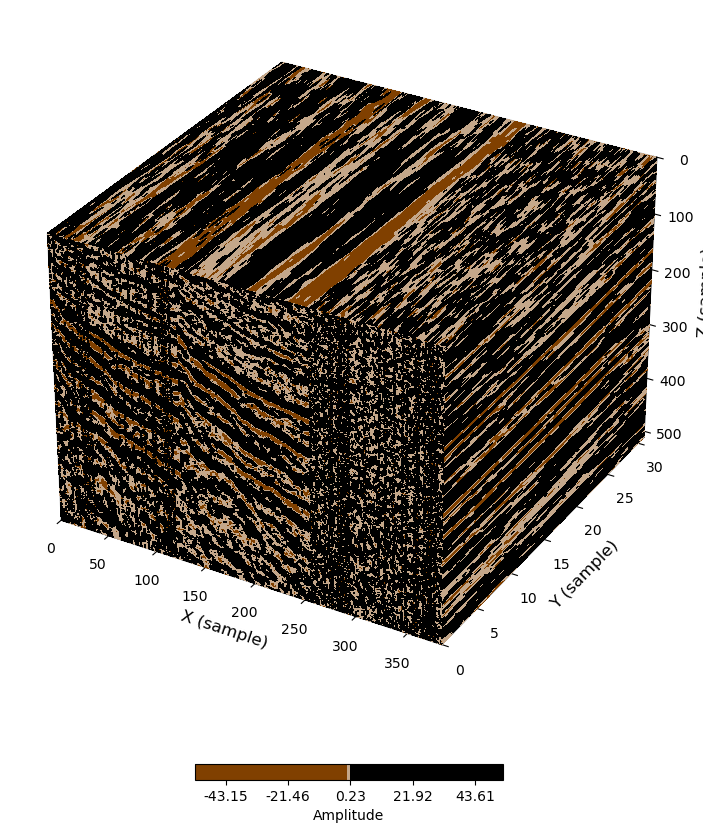

In [44]:
# Not too bad
# Keep increasing cvalue!
cvalue=1.3
cvalue=0.9
cvalue=10.0
cvalue=20.0
def huber_loss_mean(y_true, y_pred, clip_delta=cvalue):
    error = y_true - y_pred
    abs_error = tf.keras.backend.abs(error)

    squared_loss = 0.5 * tf.keras.backend.square(error)
    linear_loss = clip_delta * (abs_error - 0.5 * clip_delta)

    return tf.keras.backend.mean(tf.where(abs_error < clip_delta, squared_loss, linear_loss))


autoencoder.compile(optimizer="adam", loss=huber_loss_mean) #from loss='mse'

# specify the model
import datetime
today=datetime.date.today()
weightname='best_model_%s.weights.h5'%str(today)
checkpoint = ModelCheckpoint(filepath=weightname,monitor='val_loss',mode = 'min',verbose=1,save_weights_only=True,save_best_only=True)
lr_reducer = ReduceLROnPlateau(factor=0.1,cooldown=0,patience=50,min_lr=0.5e-6,monitor='val_loss',mode = 'min',verbose= 1)

autoencoder.fit(Xnoisy,Xnoisy, batch_size=128, verbose=1,epochs=20,callbacks=[checkpoint,lr_reducer],validation_split=0.2)

# Predict
Xout4 = autoencoder.predict(Xnoisy)


# reconstruct data
denoised4=patch3d_inv(Xout4,nz,nx,ny,l1=16,l2=10,l3=10,s1=8,s2=2,s3=2);

# Plot patch comparison
plt.figure(figsize=(8,8))
for ii in range(16):
            ax=plt.subplot(4,4,ii+1,projection='3d')
            plot3d(Xnoisy[600+ii,:].reshape(16,10,10,order='F'),ifnewfig=False,showf=False,close=False)
            plt.gca().axis('off')
ax = plt.gcf().add_subplot(111, aspect='auto');plt.gca().axis('off');plt.title("Noisy Patches",size=20)
plt.show()

plt.figure(figsize=(8,8))
for ii in range(16):
            ax=plt.subplot(4,4,ii+1,projection='3d')
            plot3d(Xout4[600+ii,:].reshape(16,10,10,order='F'),ifnewfig=False,showf=False,close=False)
            plt.gca().axis('off')
ax = plt.gcf().add_subplot(111, aspect='auto');plt.gca().axis('off');plt.title("Denoised Patches",size=20)
plt.show()


# Plot denoising comparison
plot3d(np.concatenate([real2,denoised4,real2-denoised4],axis=1),vmin=-1,vmax=1,figsize=(14,10),z=np.arange(nz)*dz,x=np.arange(nx*3)*dx,y=np.arange(ny)*dy,barlabel='Amplitude',showf=False,close=False)
plt.gca().set_xlabel("X (sample)",fontsize='large', fontweight='normal')
plt.gca().set_ylabel("Y (sample)",fontsize='large', fontweight='normal')
plt.gca().set_zlabel("Z (sample)",fontsize='large', fontweight='normal')
plt.savefig(fname='real3d-denoised-erratic-huber4.png',format='png',dpi=300)
plt.show()



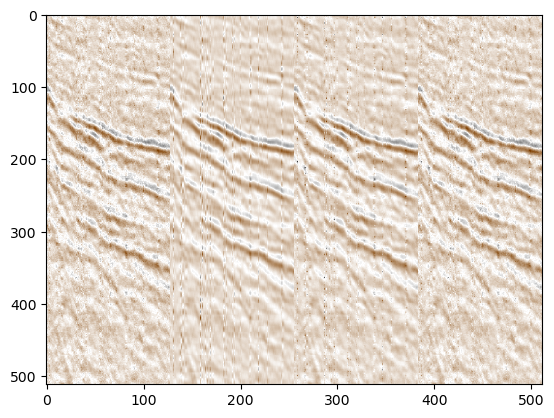

In [45]:
plt.imshow(np.concatenate([denoised[:,:,ind],denoised2[:,:,ind],denoised3[:,:,ind],denoised4[:,:,ind]],axis=1),aspect='auto',cmap=pyseistr.cseis());

# It is closer and closer to no Huber norm constraint as cvalue increases